##  Univariate time series forecasting test on PC4 5501 using XGBOOST


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
!pip install altair
import altair as alt

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import plot_importance, plot_tree


# show all columns in the dataframe
pd.set_option('max_columns', None)

In [2]:
os.getcwd()

'C:\\Users\\jcdek\\OneDrive\\Documents\\GitHub\\jads_enexis\\notebooks'

In [3]:
# variables used in script
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

# kleinverbruikgegevens gegevens inlezen
df_nedu = pd.read_hdf('nedu_files.h5')


In [5]:
# Scale all profiles for better forecasts
df_nedu['E1A'] = df_nedu['E1A'] * 1000000 
df_nedu['E1B'] = df_nedu['E1B'] * 1000000 
df_nedu['E1C'] = df_nedu['E1C'] * 1000000 
df_nedu['E2A'] = df_nedu['E2A'] * 1000000 
df_nedu['E2B'] = df_nedu['E2B'] * 1000000 
df_nedu['E3A'] = df_nedu['E3A'] * 1000000 
df_nedu['E3B'] = df_nedu['E3B'] * 1000000 
df_nedu['E3C'] = df_nedu['E3C'] * 1000000 
df_nedu['E3D'] = df_nedu['E3D'] * 1000000 
df_nedu['E4A'] = df_nedu['E4A'] * 1000000 

In [6]:
df_nedu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421015 entries, 0 to 421014
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   DatumTijd  420768 non-null  datetime64[ns]
 1   E1A        420768 non-null  float64       
 2   E1B        420768 non-null  float64       
 3   E1C        420768 non-null  float64       
 4   E2A        420768 non-null  float64       
 5   E2B        420768 non-null  float64       
 6   E3A        420768 non-null  float64       
 7   E3B        420768 non-null  float64       
 8   E3C        420768 non-null  float64       
 9   E3D        420768 non-null  float64       
 10  E4A        420768 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 38.5 MB


### Building Training/ Test Samples

In [7]:
# date where to split train and test
split_date = '01-Jan-2019'
# starting date of train dataset
from_date = '01-Jan-2010'

df_nedu_train = df_nedu.loc[(df_nedu['DatumTijd'] >= from_date) & (df_nedu['DatumTijd'] <= split_date) ].copy()
df_nedu_test = df_nedu.loc[df_nedu['DatumTijd'] > split_date].copy()
print (f'Length full     dataset: {len(df_nedu)} samples')
print (f'Length training dataset: {len(df_nedu_train)} samples')
print (f'Length test     dataset: {len(df_nedu_test)} samples')


Length full     dataset: 421015 samples
Length training dataset: 315552 samples
Length test     dataset: 105216 samples


### Feature engineering

In [8]:
# Create features from datetime index
def create_features(df, label=None):
    df['date'] = df['DatumTijd']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['hour'] = df['date'].dt.hour
    dt_minute = df['date'].dt.minute
    df['15min'] = 15*(dt_minute // 15)
    
    X = df[['dayofweek','month', 'quarter', 'year', 'dayofyear','dayofmonth', 'weekofyear','hour', '15min']]
    if label:
        y = df[label]
        return X, y
    return X

In [9]:
# Profile to be predicted
profile='E1A'

In [10]:
# Create trainign and test datasets
X_train, y_train = create_features(df_nedu_train, label=profile)
X_test, y_test = create_features(df_nedu_test, label=profile)

<ipython-input-8-d28113541d05>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


### Build XGBoost Model

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000, subsample=1.0, min_child_weight=2, max_depth=8, learning_rate=0.15,
                       gamma=0, colsample_bytree=0.9)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=8,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Plot Feature Importances

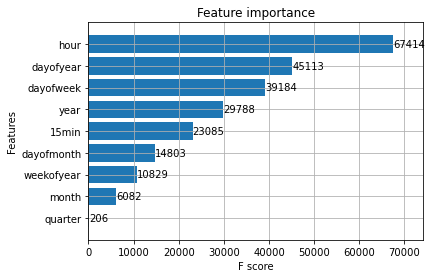

In [12]:
plot_importance(reg, height=0.8);

### Forecast on Test Set

In [13]:
df_nedu_test['Forecast'] = reg.predict(X_test)

In [15]:
df_nedu_all = pd.concat([df_nedu_test, df_nedu_train], sort = False)

<AxesSubplot:>

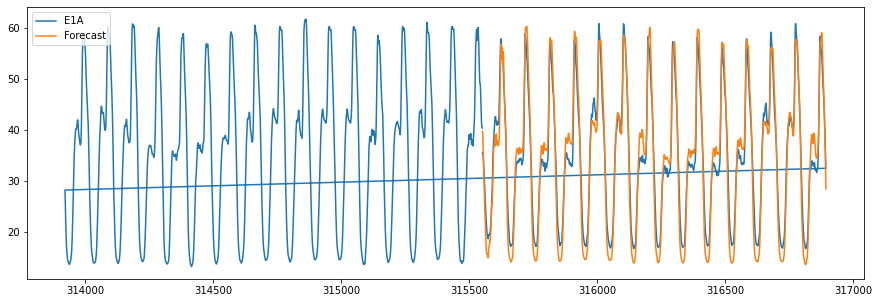

In [18]:
df_nedu_all.loc[(df_nedu_all['DatumTijd'] > '15-Dec-2018') & (df_nedu_all['DatumTijd'] < '15-Jan-2019')][[profile, 'Forecast']].plot(figsize=(15,5))

<AxesSubplot:>

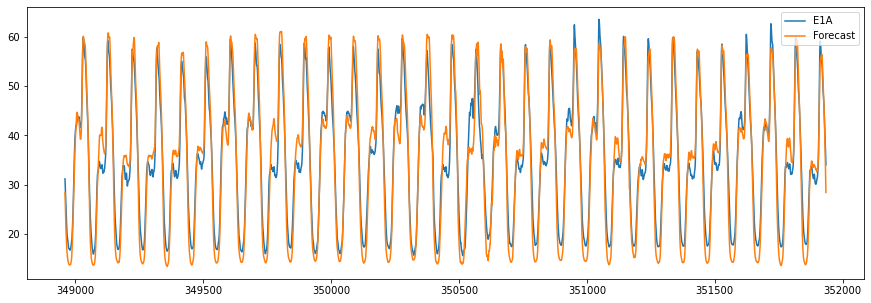

In [19]:
df_nedu_all.loc[(df_nedu_all['DatumTijd'] > '15-Dec-2019') & (df_nedu_all['DatumTijd'] < '15-Jan-2020')][[profile, 'Forecast']].plot(figsize=(15,5))

<AxesSubplot:>

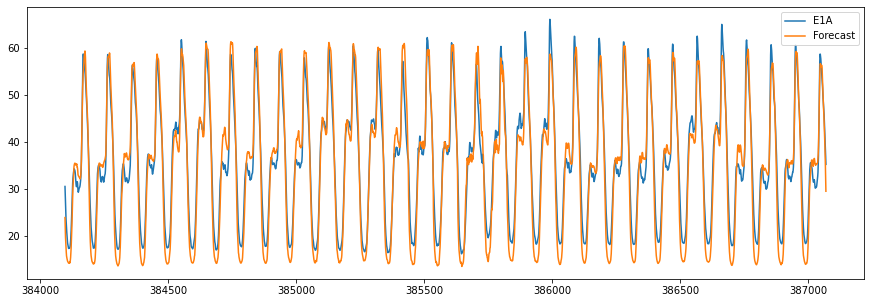

In [17]:
df_nedu_all.loc[(df_nedu_all['DatumTijd'] > '15-Dec-2020') & (df_nedu_all['DatumTijd'] < '15-Jan-2021')][[profile, 'Forecast']].plot(figsize=(15,5))

### Evaluate the Performance

In [20]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
# Make predictions using the training and testing set
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [22]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

print(f'\nMean absolute percent accuracy: {100 - mean_absolute_percentage_error(y_test, y_test_pred):.2f}%')

R^2   train: 1.00, test: 0.86
MSE   train: 0.10, test: 14.41
RMSE  train: 0.31, test: 3.80
MAE   train: 0.22, test: 3.11
MAPE  train: 0.80, test: 13.25

Mean absolute percent accuracy: 86.75%


### RandomizedSearch Hyperparameter optimization

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=7)
param_dist = {
    "max_depth": [3, 4, 5, 10, 25],
    "learning_rate": [0.01, 0.05, 0.1, 0.15],
    "num_leaves": [50, 100, 200],
    "n_estimators": [50, 100, 150],
    'min_child_weight': [1, 2, 5],
    'gamma': [0, 0.1, 0.5, 1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.9, 0.95, 1.0],
}
xgb_rgs = xgb.XGBRegressor(random_state=666)
xgb_gs = RandomizedSearchCV(xgb_rgs, 
                           n_jobs=6, 
                           n_iter=500,
                           param_distributions=param_dist, 
                           cv = tscv, 
                           scoring="neg_mean_absolute_error", 
                           verbose=5, random_state=666)
xgb_gs.fit(X_train, y_train)

In [ ]:
xgb_gs.best_params_

In [ ]:
search = clf.fit(iris.data, iris.target)
>>> search.best_params_